# Empirical Orthogonal Function (EOF)

### In this tutorial, we focus on the SST anomalies of Pacific Ocean.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import xarray as xr
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Import the EOF function from Pycurrents Package
from pycurrents.num import eof

In [3]:
ncfile1 = '~/project/mc2019/public/Tutorial-03/sst.mnmean.nc'
ds1 = xr.open_dataset(ncfile1)
print(ds1)

ncfile2 = '~/project/mc2019/public/Tutorial-03/lsmask.nc'
ds2 = xr.open_dataset(ncfile2)
print(ds2)

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, nbnds: 2, time: 455)
Coordinates:
  * lat        (lat) float32 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon        (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time       (time) datetime64[ns] 1981-12-01 1982-01-01 ... 2019-10-01
Dimensions without coordinates: nbnds
Data variables:
    sst        (time, lat, lon) float32 ...
    time_bnds  (time, nbnds) datetime64[ns] ...
Attributes:
    title:          NOAA Optimum Interpolation (OI) SST V2
    Conventions:    CF-1.0
    history:        Wed Apr  6 13:47:45 2005: ncks -d time,0,278 SAVEs/sst.mn...
    comments:       Data described in  Reynolds, R.W., N.A. Rayner, T.M.\nSmi...
    platform:       Model
    source:         NCEP Climate Modeling Branch
    institution:    National Centers for Environmental Prediction
    References:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    dataset_title:  NOAA Optimum Interpolation (OI) SST V

In [4]:
time = ds1['time'][:]
lat  = ds1['lat'][:]                       
lon  = ds1['lon'][:]
sst  = ds1['sst'][:,:,:]
mask = ds2['mask'][0,:,:]

# Mask the land with zero
for i in range(0,180):
    for j in range(0,360):
        if mask[i,j]==0:
            sst[:,i,j] = 0.0

In [5]:
# Calculate the 30-year monthly mean SST
sst_30y = sst.sel(time=slice('1986','2015'))
sst_m_mean = np.zeros((12,180,360))
for i in range(0,12):
    month = sst_30y.isel(time=slice(i,360,12)).values
    monthmean = np.mean(month,axis=0)
    sst_m_mean[i,:,:] = monthmean[:,:]

In [6]:
# Calculate the anomalies
sst_37y = sst.sel(time=slice('1982','2018'))
sst_anoma = np.zeros((37*12,180,360))
for i in range(0,37*12):
    k = i % 12
    sst_anoma[i,:,:] = sst_37y.values[i,:,:] - sst_m_mean[k,:,:]

The grid is uniform in latitude and longitude, so high-latitude cells represent smaller areas than low-latitude cells. We would like the EOF spatial functions to be approximately orthogonal in an area-integrated sense.  Because this orthogonality condition involves the product of *two* EOFs, we weight the data by $\sqrt{\cos\theta}$ so that the product is weighted by $\cos\theta$, where $\theta$ is latitude.

In [7]:
latweights   = np.sqrt(np.cos(np.deg2rad(lat.values)))
latweights   = latweights[np.newaxis,:,np.newaxis]
sst_anoma_w  = sst_anoma * latweights

**Use EOF to analyze the SST anomalies data.**

In [8]:
# Do EOF analysis for 60N~60S, 120E~90W
sst_anoma_w_s = sst_anoma_w[:,30:150,120:300]

In [9]:
sst_eof = eof.EOF(sst_anoma_w_s)

**Illustrate some results of Empirical Orthogonal Function (EOF) analysis:**

<Figure size 864x288 with 0 Axes>

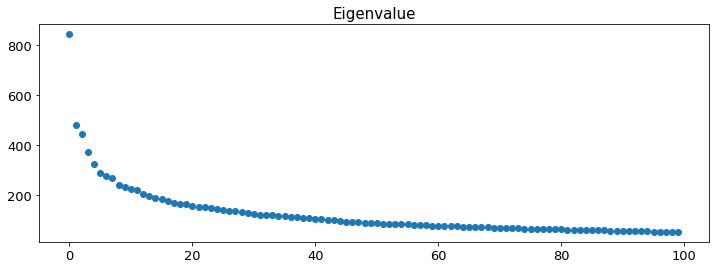

In [10]:
# Plot singular values of each EOF component
fig = plt.figure(figsize=(12,4))
plt.rcParams['figure.figsize'] = (12,4)

fig, ax = plt.subplots()
ax.plot(sst_eof.s[:100],'o')
ax.tick_params(axis='both',labelsize=13)
ax.set_title('Eigenvalue',fontsize=15)

plt.show()

<Figure size 864x288 with 0 Axes>

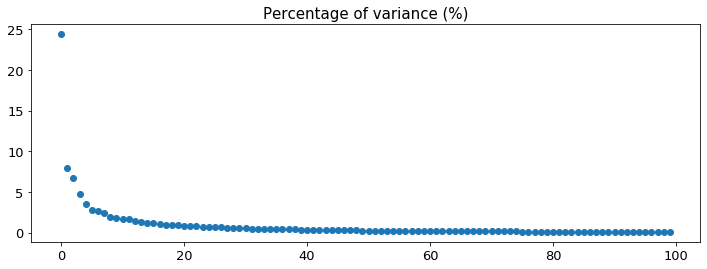

In [11]:
# Plot percentage of variance of each EOF component
fig = plt.figure(figsize=(12,4))
plt.rcParams['figure.figsize'] = (12,4)

fig, ax = plt.subplots()
ax.plot(sst_eof.percent_var()[:100],'o')
ax.tick_params(axis='both',labelsize=13)
ax.set_title('Percentage of variance (%)',fontsize=15)

plt.show()

<Figure size 1080x288 with 0 Axes>

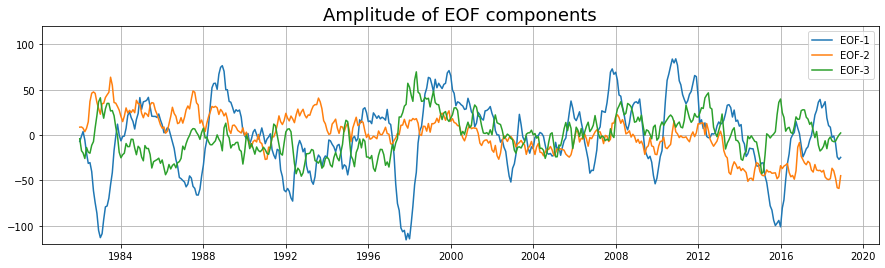

In [12]:
# Plot the amplitude of the first three EOF components
fig = plt.figure(figsize=(15,4))
plt.rcParams['figure.figsize'] = (15,4)

fig, ax = plt.subplots()
ax.plot(time.sel(time=slice('1982','2018')),sst_eof.u[:,0]*sst_eof.s[0],label='EOF-1')
ax.plot(time.sel(time=slice('1982','2018')),sst_eof.u[:,1]*sst_eof.s[1],label='EOF-2')
ax.plot(time.sel(time=slice('1982','2018')),sst_eof.u[:,2]*sst_eof.s[2],label='EOF-3')
ax.set_ylim(-120,120)
ax.grid()

ax.set_title('Amplitude of EOF components',fontsize=18)

plt.legend()
plt.show()

In [13]:
# Plot the trend of EOF-2
def plot_trendline(x,y,n):
    fig = plt.figure(figsize=(15,4))
    plt.rcParams['figure.figsize'] = (15,4)
    plt.plot(x,y)
    parameter = np.polyfit(x,y,n)
    f = np.poly1d(parameter)
    plt.plot(x,f(x),'r')
    plt.title('Trend of EOF-2,  Slope=%.3f,  Intercept=%.3f'%(parameter[0],parameter[1]),fontsize=18)
    plt.grid()
    plt.show()

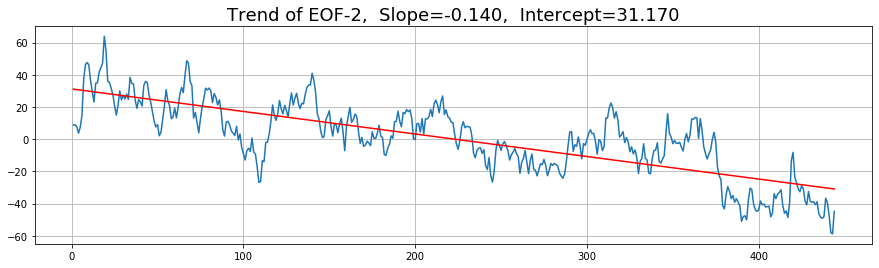

In [14]:
plot_trendline(range(1,445),sst_eof.u[:,1]*sst_eof.s[1],1)

In [15]:
# Undo the latitude weighting
spatial_data_w = sst_eof.v_reshaped
spatial_data   = spatial_data_w / latweights[:,30:150,:]

# Mask the spatial data
for i in range(0,120):
    for j in range(0,180):
        if mask[i+30,j+120]==0:
            spatial_data[:,i,j] = 'NaN'

In [16]:
def plotmap():
    plt.figure(figsize=(15,10))
    plt.rcParams['figure.figsize'] = (12,8)
    
    proj = ccrs.PlateCarree(central_longitude=180)
    fig,ax = plt.subplots(subplot_kw=dict(projection=proj))
    
    ax.set_xticks([150,180,210,240,270],crs=ccrs.PlateCarree())
    ax.set_yticks([-90,-60,-30,0,30,60,90],crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(axis='both',labelsize=13)

    ax.coastlines(zorder=10)
    ax.gridlines(xlocs=np.arange(0,361,30), ylocs=np.arange(-90,91,30))
    
    return fig,ax

<Figure size 1080x720 with 0 Axes>

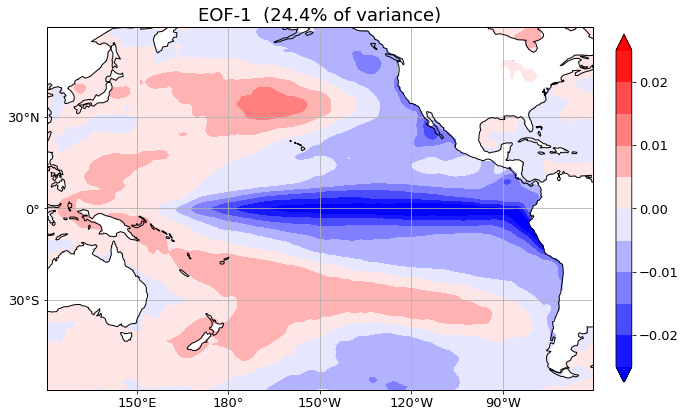

In [17]:
fig,ax = plotmap()

plotx_data = spatial_data[0,:,:]

levelx = np.arange(-0.025,0.026,0.005)
plotx_plot = ax.contourf(np.arange(120.5,300.5,1),np.arange(59.5,-60.5,-1),plotx_data,levels=levelx,cmap='bwr',
                         extend='both',zorder=1,transform=ccrs.PlateCarree())

cbar = plt.colorbar(plotx_plot,shrink=0.8,pad=0.035)
cbar.ax.tick_params(labelsize=13)

ax.set_title('EOF-1  (%.1f%% of variance)'%(sst_eof.percent_var()[0]),fontsize=18)

plt.show()

<Figure size 1080x720 with 0 Axes>

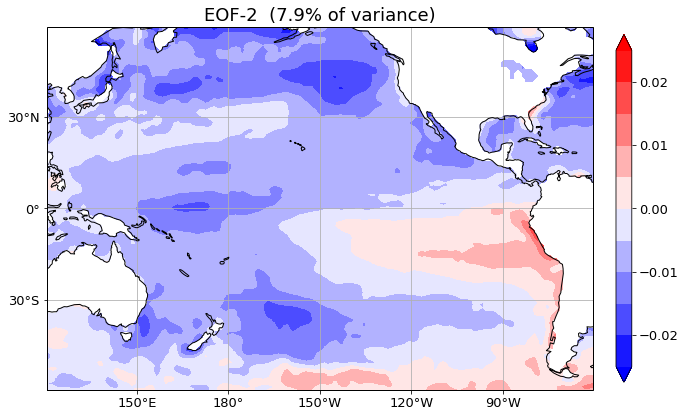

In [18]:
fig,ax = plotmap()

plotx_data = spatial_data[1,:,:]

levelx = np.arange(-0.025,0.026,0.005)
plotx_plot = ax.contourf(np.arange(120.5,300.5,1),np.arange(59.5,-60.5,-1),plotx_data,levels=levelx,cmap='bwr',
                         extend='both',zorder=1,transform=ccrs.PlateCarree())

cbar = plt.colorbar(plotx_plot,shrink=0.8,pad=0.035)
cbar.ax.tick_params(labelsize=13)

ax.set_title('EOF-2  (%.1f%% of variance)'%(sst_eof.percent_var()[1]),fontsize=18)

plt.show()

<Figure size 1080x720 with 0 Axes>

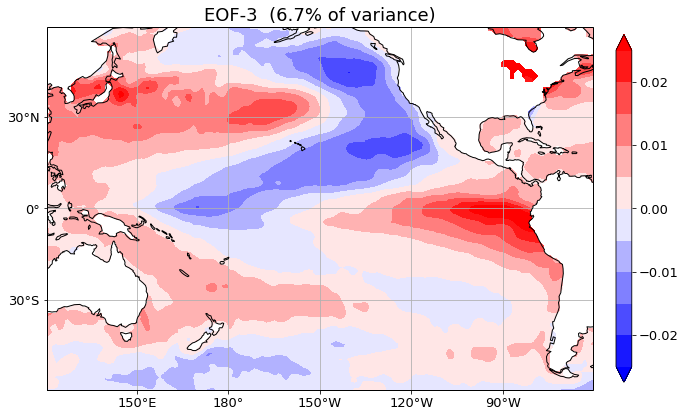

In [19]:
fig,ax = plotmap()

plotx_data = spatial_data[2,:,:]

levelx = np.arange(-0.025,0.026,0.005)
plotx_plot = ax.contourf(np.arange(120.5,300.5,1),np.arange(59.5,-60.5,-1),plotx_data,levels=levelx,cmap='bwr',
                         extend='both',zorder=1,transform=ccrs.PlateCarree())

cbar = plt.colorbar(plotx_plot,shrink=0.8,pad=0.035)
cbar.ax.tick_params(labelsize=13)

ax.set_title('EOF-3  (%.1f%% of variance)'%(sst_eof.percent_var()[2]),fontsize=18)

plt.show()

Use the first two EOF components to reconstruct the SST anomalies.

<Figure size 1080x720 with 0 Axes>

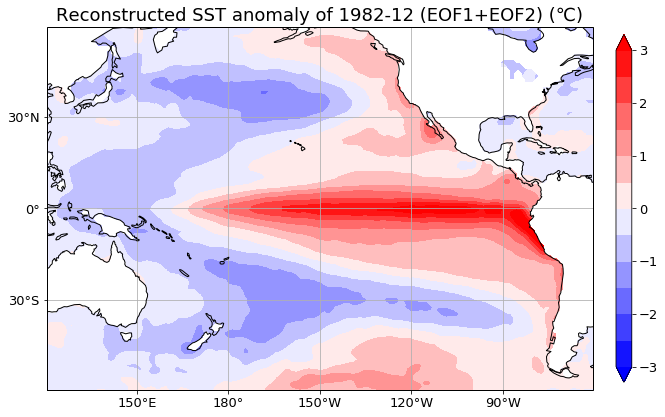

In [20]:
fig,ax = plotmap()

# Construct the SST anomaly of 1982-12, one of the 'super' El Niños
plotx_data = spatial_data[0,:,:]*sst_eof.u[11,0]*sst_eof.s[0] + spatial_data[1,:,:]*sst_eof.u[11,1]*sst_eof.s[1]

levelx = np.arange(-3,3.1,0.5)
plotx_plot = ax.contourf(np.arange(120.5,300.5,1),np.arange(59.5,-60.5,-1),plotx_data,levels=levelx,cmap='bwr',
                         extend='both',zorder=1,transform=ccrs.PlateCarree())

cbar = plt.colorbar(plotx_plot,shrink=0.8,pad=0.035)
cbar.ax.tick_params(labelsize=13)

ax.set_title('Reconstructed SST anomaly of 1982-12 (EOF1+EOF2) (℃)',fontsize=18)

plt.show()

Plot the origional SST anomaly. They are very similar to each other.

In [21]:
# Mask the origional SST anomaly data
for i in range(0,180):
    for j in range(0,360):
        if mask[i,j]==0:
            sst_anoma[:,i,j] = 'NaN'

<Figure size 1080x720 with 0 Axes>

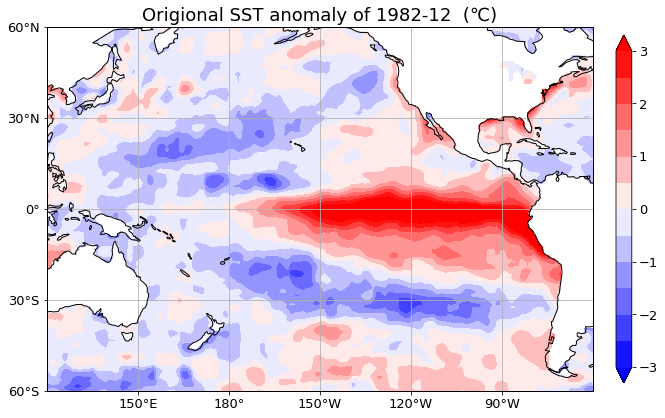

In [22]:
fig,ax = plotmap()

# Origional SST anomaly of 1982-12
plotx_data = sst_anoma[11,:,:]

levelx = np.arange(-3,3.1,0.5)
plotx_plot = ax.contourf(lon,lat,plotx_data,levels=levelx,cmap='bwr',extend='both',zorder=1,transform=ccrs.PlateCarree())

cbar = plt.colorbar(plotx_plot,shrink=0.8,pad=0.035)
cbar.ax.tick_params(labelsize=13)

ax.set_extent([120,300,-60,60],crs=ccrs.PlateCarree())

ax.set_title('Origional SST anomaly of 1982-12  (℃)',fontsize=18)

plt.show()